In [16]:
import json
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [17]:
filePlane = open(r"Q:\Python_Data\planesnet\planesnet.json")
planeDataSet = json.load(filePlane)

In [18]:
planeDataSet.keys()

dict_keys(['data', 'labels', 'locations', 'scene_ids'])

In [19]:
plane_x = np.array(planeDataSet['data']).astype('uint8')
plane_y = np.array(planeDataSet['labels']).astype('uint8')

In [20]:
# int8 : 8비트 정수를 표현
# 양수음수 1비트 때문에 숫자에 해당되는 것은 7비트
# -128~127 까지를 표현할 수 있다.

# uint : unsigned int 
# 음수를 표현하지 않음, 양의 정수만 표현
# 0~255 까지를 표현한다. 
# 데이터 크기가 크므로 메모리를 효율적으로 
# 사용하기 위해서 uint8을 사용하는 현명한 선택!

In [21]:
print(plane_x.shape, plane_y.shape)

(32000, 1200) (32000,)


In [22]:
plane_x = plane_x.reshape([-1,3,20,20]).transpose([0,2,3,1])
# transpose 0번째, 2번쨰, 3번쨰, 1번째 순서로 차원이 변경됨

# ? 왜 3, 20, 20 인거지??
# 사용하는 플렛폼에 따라서 채널이 어디로 갈지 알 수 없음
# 그것을 찾아서 확인해야함

In [23]:
plane_x.shape

(32000, 20, 20, 3)

In [24]:
shuffle_idx = np.arange(32000)
np.random.shuffle(shuffle_idx)
shuffle_idx

array([25671, 12556, 20567, ..., 20542,  1889,  8577])

In [25]:
plane_x = plane_x[shuffle_idx]
plane_y = plane_y[shuffle_idx]

In [26]:
plane_x = plane_x/255.0

In [27]:
plane_classes={0:'No Plane',1:'Plane'}

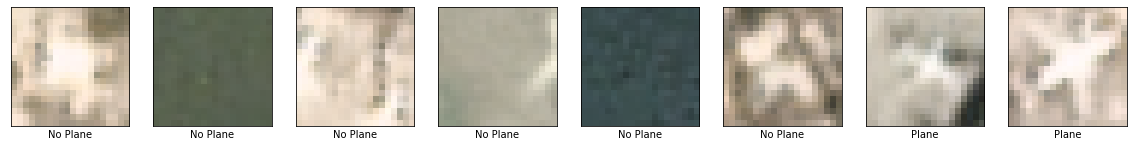

In [30]:
plt.figure(figsize=(20,10))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plane_x[i], cmap=plt.cm.binary)
    plt.xlabel(plane_classes[plane_y[i]])

In [31]:
Xtrn, Xtst, ytrn, ytst = train_test_split(plane_x, plane_y,
                                         test_size=0.2)

함수 형식으로 모델 만들기

In [34]:
def cnn_model(inputshape):
    model=tf.keras.Sequential([
        keras.layers.Conv2D(32,(5,5),input_shape=inputshape, activation='relu',padding='same'),
        keras.layers.Conv2D(64,(5,5),activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Dropout(0.25),

        keras.layers.Conv2D(128,(5,5), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Dropout(0.25),    
        keras.layers.Flatten(),
        
        keras.layers.Dense(512,activation='relu'),
        keras.layers.Dropout(0.35),    
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dropout(0.35),           
        keras.layers.Dense(2,activation='softmax')        
    ]) 
    model.summary()
    return(model)

In [58]:
training_plane=cnn_model((20,20,3))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 20, 20, 32)        2432      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 128)        

In [59]:
import os
checkpoint_path1="cp.ckpt"
checkpoint_dir1=os.path.dirname(
    checkpoint_path1)

In [60]:
cp_callback1=tf.keras.callbacks.ModelCheckpoint(checkpoint_path1,
                                  save_weights_only=True,
                                  verbose=1)

In [61]:
training_plane.compile(optimizer=tf.keras.optimizers.Adam(), 
                      loss=tf.keras.losses.sparse_categorical_crossentropy,
                      metrics=['accuracy'])

In [62]:
import time

start_time_plane = time.time()
history = training_plane.fit(Xtrn, ytrn,    
                                  validation_split=0.33, epochs=5,   
                                  callbacks=[cp_callback1], batch_size=256)
traing_time_plane = time.time()-start_time_plane
"""
model.fit(...., validation_data(xVal,yVal))

validation_split=0.33
xTrain, yTrain을 33% 분리하여 검증데이터로 사용

"""

Train on 17152 samples, validate on 8448 samples
Epoch 1/5
16896/17152 [============================>.] - ETA: 0s - loss: 0.4836 - acc: 0.7652
Epoch 00001: saving model to cp.ckpt
17152/17152 [==============================] - 5s 267us/sample - loss: 0.4823 - acc: 0.7658 - val_loss: 0.4074 - val_acc: 0.7867
Epoch 2/5
16896/17152 [============================>.] - ETA: 0s - loss: 0.3362 - acc: 0.8399
Epoch 00002: saving model to cp.ckpt
17152/17152 [==============================] - 4s 247us/sample - loss: 0.3349 - acc: 0.8409 - val_loss: 0.2290 - val_acc: 0.9019
Epoch 3/5
16896/17152 [============================>.] - ETA: 0s - loss: 0.2126 - acc: 0.9114
Epoch 00003: saving model to cp.ckpt
17152/17152 [==============================] - 4s 248us/sample - loss: 0.2125 - acc: 0.9115 - val_loss: 0.1811 - val_acc: 0.9303
Epoch 4/5
16896/17152 [============================>.] - ETA: 0s - loss: 0.1707 - acc: 0.9338
Epoch 00004: saving model to cp.ckpt
17152/17152 [===========================

'\nmodel.fit(...., validation_data(xVal,yVal))\n\nvalidation_split=0.33\nxTrain, yTrain을 33% 분리하여 검증데이터로 사용\n\n'

In [63]:
traing_time_plane

22.438621282577515

No handles with labels found to put in legend.


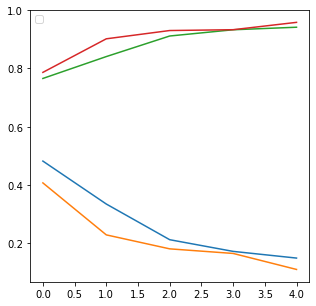

In [84]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend()

In [70]:
training_plane.evaluate(Xtst, ytst) # 95%

6400/6400 [==============================] - 1s 232us/sample - loss: 0.1065 - acc: 0.9598


[0.10653992648236453, 0.95984375]

In [92]:
classification_plane=training_plane.predict(Xtst)
classification_plane

array([[9.9947625e-01, 5.2374700e-04],
       [9.9769694e-01, 2.3030096e-03],
       [9.9586654e-01, 4.1334620e-03],
       ...,
       [9.7848696e-01, 2.1512968e-02],
       [3.0213432e-02, 9.6978652e-01],
       [9.5197320e-01, 4.8026793e-02]], dtype=float32)

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(classification_plane, axis=1), ytst)
# 95% 정답률

0.95984375